# Thin Aluminium Plate

In [1]:
%matplotlib inline

In [2]:
import pathlib
import numpy as np
import h5py
import os
import scipy.io
import salvus.namespace as sn
from salvus.project.tools.processing import block_processing
from salvus.toolbox.helpers.wavefield_output import (
    WavefieldOutput,
    wavefield_output_to_xarray,
)
import xarray as xr


   ┌────────────────────────────────────────────────────────────────────────────────────┐
   │                                                                                    │
   │   Salvus update available!                                                         │
   │                                                                                    │
   │   2024.1.3 → 2025.1.0                                                              │
   │                                                                                    │
   │   See https://mondaic.com/docs/updates/changelog                                   │
   │   for a list of changes and new features.                                          │
   │                                                                                    │
   │   To upgrade, please first make sure that your python environment is up to date:   │
   │                                                                                    │
   │   ht

In [3]:
import os

SALVUS_FLOW_SITE_NAME = os.environ.get("SITE_NAME", "local")
PROJECT_DIR = "alu_plate_9mm_50x50cm_T10ms_Ricker_fc50kHz_Q_250"

# Homogneneous Calibration
SIM_NAME_HOMO = "fz_homo_q"
# Defect A
SIM_NAME_DEFECT_A = "fz_defect_A"
# Defect A
SIM_NAME_DEFECT_B = "fz_defect_B"
# Defect A
SIM_NAME_DEFECT_C = "fz_defect_C"


# Uncomment the following line to delete a
# potentially existing project for a fresh start
# !rm -rf project

In [4]:
# Model Dimensions
x_max = 0.50
y_max = 0.50
z_max = 9e-3


In [5]:
# Aluminum Model Paramteters
vp0 = 6142.03
vs0 = 3093.85
rho0 = 2710

Q = 250

In [6]:
# Simulation Parameters
fc = 50e3
t0 = 0.0
T = 10e-3

In [7]:
# Base Model Domain
d = sn.domain.dim3.BoxDomain(
    x0=0.0, x1=x_max, y0=0.0, y1=y_max, z0=0.0, z1=z_max
)

In [8]:
p = sn.Project.from_domain(path=PROJECT_DIR, domain=d, load_if_exists=True)

Accordion(children=(HTML(value='\n                <head>\n                <style>\n                td {\n     …

[2025-07-02 13:21:39,416] INFO: Loading project from alu_plate_9mm_50x50cm_T10ms_Ricker_fc50kHz_Q_250.


In [ ]:
# Homo Mesh

material_homo = sn.material.from_params(
    vp=vp0,
    vs=vs0,
    rho=rho0,
    qmu=Q,
    qkappa=Q,
)

# Because we can't attach linear solids to a material, we need to create a
# layered model with a single layer and no interfaces.
model = sn.layered_meshing.LayeredModel(
    strata=[material_homo],
    linear_solids=sn.LinearSolids(reference_frequency=fc),
)

mesh_homo = sn.layered_meshing.mesh_from_domain(
    domain=d,
    model=model,
    mesh_resolution=sn.MeshResolution(
        reference_frequency=2.5*fc,
        elements_per_wavelength=2.0,
        model_order=4,
    ),
)

mesh_homo

In [10]:
# Defect Mesh 

import xarray as xr

# Grid setup
x = np.linspace(0, x_max, 200)
y = np.linspace(0, y_max, 200)
X, Y = np.meshgrid(x, y, indexing="ij")


# Generalized defect property function
def smooth_defect_property(
    x, y, center_x, center_y, size, taper_fraction, prop0, prop_defect
):
    r = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
    prop = np.ones_like(r) * prop0

    r_core = (1 - taper_fraction) * size / 2
    r_outer = (1 + taper_fraction) * size / 2

    # Core region
    inside_core = r <= r_core
    prop[inside_core] = prop_defect

    # Transition zone
    in_transition = (r > r_core) & (r <= r_outer)
    frac = (r[in_transition] - r_core) / (r_outer - r_core)
    w = 0.5 * (1 + np.cos(np.pi * frac))  # Cosine taper
    prop[in_transition] = w * prop_defect + (1 - w) * prop0

    return prop

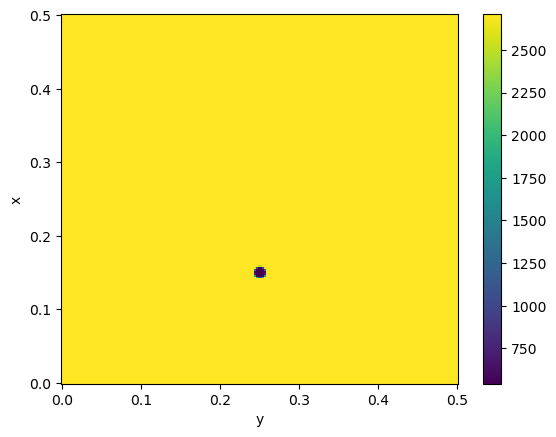

In [13]:

# Density Defect 
rho_defect = 0.2 * rho0

# DEFECT A
defect_x = 0.3 * x_max
defect_y = 0.5 * y_max

rho = xr.DataArray(
    data=smooth_defect_property(
        X,
        Y,
        center_x=defect_x,
        center_y=defect_y,
        size=0.015,
        taper_fraction=0.2,
        prop0=rho0,
        prop_defect=rho_defect,
    ),
    dims=["x", "y"],
    coords={"x": x, "y": y},
)

rho.plot()

material_varying = sn.material.from_params(
    vp=vp0,
    vs=vs0,
    rho=rho,
    qmu=Q,
    qkappa=Q,
)

# Because we can't attach linear solids to a material, we need to create a
# layered model with a single layer and no interfaces.
model = sn.layered_meshing.LayeredModel(
    strata=[material_varying],
    linear_solids=sn.LinearSolids(reference_frequency=fc),
)

mesh_defect_A = sn.layered_meshing.mesh_from_domain(
    domain=d,
    model=model,
    mesh_resolution=sn.MeshResolution(
        reference_frequency=2.5 * fc,
        elements_per_wavelength=2.0,
        model_order=4,
    ),
)

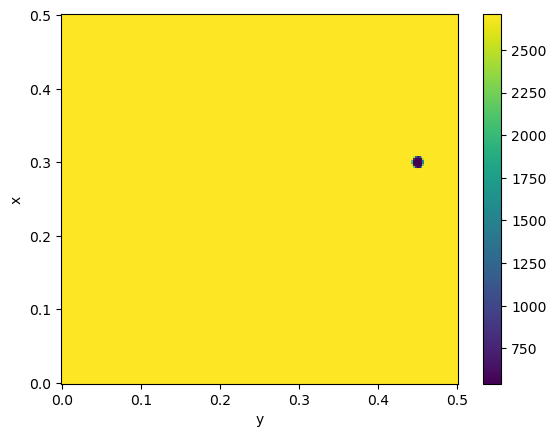

In [12]:
# DEFECT B
defect_x = 0.6 * x_max
defect_y = 0.9 * y_max

rho = xr.DataArray(
    data=smooth_defect_property(
        X,
        Y,
        center_x=defect_x,
        center_y=defect_y,
        size=0.015,
        taper_fraction=0.2,
        prop0=rho0,
        prop_defect=rho_defect,
    ),
    dims=["x", "y"],
    coords={"x": x, "y": y},
)

rho.plot()

material_varying = sn.material.from_params(
    vp=vp0,
    vs=vs0,
    rho=rho,
    qmu=Q,
    qkappa=Q,
)

# Because we can't attach linear solids to a material, we need to create a
# layered model with a single layer and no interfaces.
model = sn.layered_meshing.LayeredModel(
    strata=[material_varying],
    linear_solids=sn.LinearSolids(reference_frequency=fc),
)

mesh_defect_B = sn.layered_meshing.mesh_from_domain(
    domain=d,
    model=model,
    mesh_resolution=sn.MeshResolution(
        reference_frequency=2.5 * fc,
        elements_per_wavelength=2.0,
        model_order=4,
    ),
)

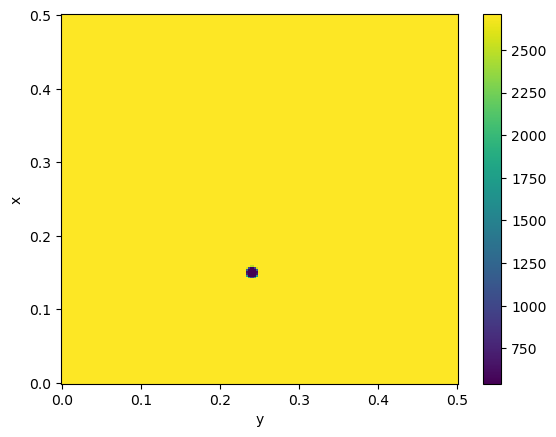

In [13]:
# DEFECT C
defect_x = 0.3 * x_max
defect_y = 0.48 * y_max

rho = xr.DataArray(
    data=smooth_defect_property(
        X,
        Y,
        center_x=defect_x,
        center_y=defect_y,
        size=0.015,
        taper_fraction=0.2,
        prop0=rho0,
        prop_defect=rho_defect,
    ),
    dims=["x", "y"],
    coords={"x": x, "y": y},
)

rho.plot()

material_varying = sn.material.from_params(
    vp=vp0,
    vs=vs0,
    rho=rho,
    qmu=Q,
    qkappa=Q,
)

# Because we can't attach linear solids to a material, we need to create a
# layered model with a single layer and no interfaces.
model = sn.layered_meshing.LayeredModel(
    strata=[material_varying],
    linear_solids=sn.LinearSolids(reference_frequency=fc),
)

mesh_defect_C = sn.layered_meshing.mesh_from_domain(
    domain=d,
    model=model,
    mesh_resolution=sn.MeshResolution(
        reference_frequency=2.5 * fc,
        elements_per_wavelength=2.0,
        model_order=4,
    ),
)

In [14]:
dt = 1.25e-7
fs = 1 / dt
fs

8000000.0

In [ ]:
wsc = sn.WaveformSimulationConfiguration(
    start_time_in_seconds=t0,
    end_time_in_seconds=T,
    time_step_in_seconds=dt,
    attenuation=True,
)

In [ ]:
# define ricker function 


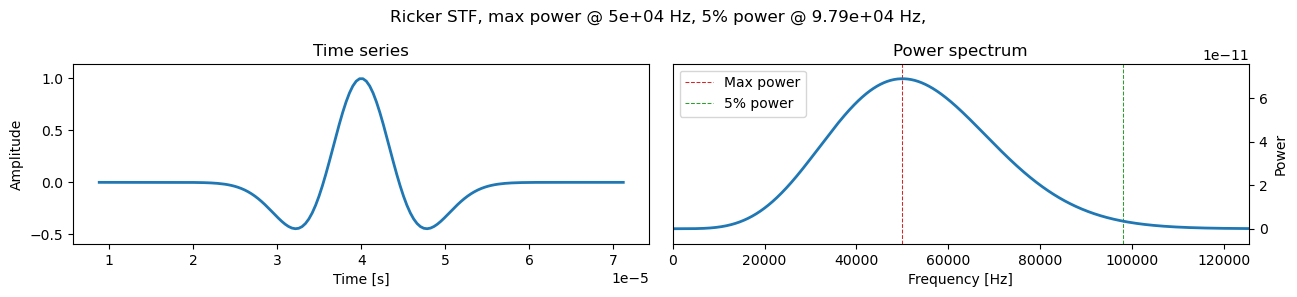

In [16]:
ec = sn.EventConfiguration(
    wavelet=sn.simple_config.stf.Ricker(
        center_frequency=fc, time_shift_in_seconds=40e-6
    ),
    waveform_simulation_configuration=wsc,
)

ec.wavelet.plot()

In [15]:
src01 = [0.50 * x_max, 0.55 * y_max, z_max]
src02 = [0.20 * x_max, 0.25 * y_max, z_max]
src03 = [0.25 * x_max, 0.80 * y_max, z_max]
src04 = [0.80 * x_max, 0.75 * y_max, z_max]
src05 = [0.75 * x_max, 0.20 * y_max, z_max]

src_all = np.stack((src01, src02, src03, src04, src05), axis=0)

In [16]:
recs = [
    sn.simple_config.receiver.cartesian.Point3D(
        x=pt[0],
        y=pt[1],
        z=pt[2],
        network_code="YY",
        station_code=f"{i:03}",
        fields=["velocity"],
    )
    for i, pt in enumerate(src_all)
]

In [17]:
src01 = sn.simple_config.source.cartesian.VectorPoint3D(
    x=src_all[0, 0], y=src_all[0, 1], z=src_all[0, 2], fx=0.0, fy=0.0, fz=1e10
)

src02 = sn.simple_config.source.cartesian.VectorPoint3D(
    x=src_all[1, 0], y=src_all[1, 1], z=src_all[1, 2], fx=0.0, fy=0.0, fz=1e10
)

src03 = sn.simple_config.source.cartesian.VectorPoint3D(
    x=src_all[2, 0], y=src_all[2, 1], z=src_all[2, 2], fx=0.0, fy=0.0, fz=1e10
)

src04 = sn.simple_config.source.cartesian.VectorPoint3D(
    x=src_all[3, 0], y=src_all[3, 1], z=src_all[3, 2], fx=0.0, fy=0.0, fz=1e10
)

src05 = sn.simple_config.source.cartesian.VectorPoint3D(
    x=src_all[4, 0], y=src_all[4, 1], z=src_all[4, 2], fx=0.0, fy=0.0, fz=1e10
)

In [18]:
p += sn.Event(event_name="fz_src01", sources=src01, receivers=recs)

p += sn.Event(event_name="fz_src02", sources=src02, receivers=recs)

p += sn.Event(event_name="fz_src03", sources=src03, receivers=recs)

p += sn.Event(event_name="fz_src04", sources=src04, receivers=recs)

p += sn.Event(event_name="fz_src05", sources=src05, receivers=recs)

[2025-07-02 13:42:45,286] INFO: An event with name 'fz_src01' and identical content already exists in the project. Nothing will be done.
[2025-07-02 13:42:46,030] INFO: An event with name 'fz_src02' and identical content already exists in the project. Nothing will be done.
[2025-07-02 13:42:46,774] INFO: An event with name 'fz_src03' and identical content already exists in the project. Nothing will be done.
[2025-07-02 13:42:47,581] INFO: An event with name 'fz_src04' and identical content already exists in the project. Nothing will be done.
[2025-07-02 13:42:48,517] INFO: An event with name 'fz_src05' and identical content already exists in the project. Nothing will be done.


In [19]:
p.viz.nb.domain()

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(100,100,100)', 'width': 4},
              'mode': 'lines',
              'name': 'Domain Outline',
              'type': 'scatter3d',
              'uid': '3e0d5e90-d83a-449c-9eb7-481390be1bb2',
              'x': array([0. , 0.5, 0.5, 0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0.5, 0.5, 0.5, 0.5,
                          0. , 0. ]),
              'y': array([0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0.5, 0.5,
                          0.5, 0.5]),
              'z': array([0.   , 0.   , 0.   , 0.   , 0.   , 0.009, 0.009, 0.009, 0.009, 0.009,
                          0.009, 0.   , 0.   , 0.009, 0.009, 0.   ])},
             {'marker': {'color': 'rgb(153, 50, 204)', 'size': 15},
              'mode': 'markers',
              'name': 'Sources',
              'text': [fz_src01 source #1, fz_src02 source #1, fz_src03 source #1,
                       fz_src04 source #1, fz_src05 source #1],
  

In [22]:
# HOMO SIM
p.add_to_project(
    sn.UnstructuredMeshSimulationConfiguration(
        name = SIM_NAME_HOMO,
        unstructured_mesh = mesh_homo,
        event_configuration = ec
    )
    )

# DEFECT A SIM
p.add_to_project(
    sn.UnstructuredMeshSimulationConfiguration(
        name=SIM_NAME_DEFECT_A,
        unstructured_mesh=mesh_defect_A,
        event_configuration=ec,
    )
)

# DEFECT B SIM
p.add_to_project(
    sn.UnstructuredMeshSimulationConfiguration(
        name=SIM_NAME_DEFECT_B,
        unstructured_mesh=mesh_defect_B,
        event_configuration=ec,
    )
)

# DEFECT C SIM
p.add_to_project(
    sn.UnstructuredMeshSimulationConfiguration(
        name=SIM_NAME_DEFECT_C,
        unstructured_mesh=mesh_defect_C,
        event_configuration=ec,
    )
)

In [20]:
p.viz.nb.simulation_setup(
    simulation_configuration=SIM_NAME_DEFECT_A, events="fz_src01"
)

In [28]:
# Determine Temporal Subsampling
fs_sb = 1.0e6
dt_sb = 1/fs_sb
sb = int(fs/fs_sb)
# sb = fs/fs_sb
sb

8

In [ ]:
# SIMULATE HOMO

p.simulations.launch(
    simulation_configuration=SIM_NAME_HOMO,
    events=p.events.list(),
    # events=p.events.list()[0],
    site_name=SALVUS_FLOW_SITE_NAME,
    ranks_per_job=4,
    extra_output_configuration={
        "surface_data": {
            "sampling_interval_in_time_steps": sb,
            "fields": ["velocity"],
            "side_sets": ["z1"],
        },
    },
)

[2025-05-28 18:15:39,498] INFO: Submitting job array with 5 jobs ...


Initializing Jobs and Uploading Files for Individual Jobs:   0%|          | 0/5 [00:00<?, ?job/s]

5

In [64]:
p.simulations.query(block=True)

VBox()

True

In [15]:
from salvus.toolbox.helpers import wavefield_output
# from scipy.io import savemat

event_list = [
    f"fz_src0{i}" for i in range(1, 6)
]  # ['fz_src01', ..., 'fz_src05']
folder_name = PROJECT_DIR + "/" +SIM_NAME_HOMO+ "/SurfaceVelocityMatlab"
os.makedirs(folder_name, exist_ok=True)
print(f"Folder '{folder_name}' created successfully!")

# Create regular grid (do this once)
dx = 5e-3
dy = dx
XX = np.arange(0, x_max + dx, dx)
YY = np.arange(0, y_max + dy, dy)
XY = [XX, YY]
field = "velocity"

# Loop over source events
for SrcEvent in event_list:
    # Get event metadata
    target_event = sn.EventData.from_output_folder(
        p.simulations.get_simulation_output_directory(
            SIM_NAME_HOMO, SrcEvent
        )
    )
    dt = target_event.meta_json_contents["forward_run_input"]["physics"][
        "wave_equation"
    ]["time_step_in_seconds"]

    dt = dt * sb

    # Load wavefield data for this event
    surface_data = (
        p.simulations.get_simulation_output_directory(
            SIM_NAME_HOMO, SrcEvent
        )
        / "surface_data_output.h5"
    )
    assert surface_data.exists(), f"Missing file: {surface_data}"

    wo = WavefieldOutput.from_file(
        filename=surface_data,
        field=field,
        output_type="surface",
        time_steps=slice(None),
    )
    wo = wo.drop_dimension(2)

    da = wavefield_output_to_xarray(
        wo,
        points=XY,
    )

    # t = np.arange(nt) * dt*sb

    # Save to .mat file
    # Savename = SIM_NAME_HOMO +  SrcEvent + "_SrcEvent.mat"
    # mdic = {"data": da, "x": XX, "y": YY, "dt": dt, "label": "srf_data"}
    # savemat(os.path.join(folder_name, Savename), mdic)

    Savename = SIM_NAME_HOMO + "_" + SrcEvent + ".h5"
    Savepath = os.path.join(folder_name, Savename)

    # Open HDF5 file (MATLAB v7.3 compatible)
    with h5py.File(Savepath, 'w') as f:
        f.create_dataset('Vz', data=da[:, 2, :, :])     # Large array
        f.create_dataset('x', data=XX)
        f.create_dataset('y', data=YY)
        f.create_dataset('dt', data=np.array([dt]))  # Ensure scalar saved properly
        f.create_dataset('label', data=np.string_('srf_data'))  # MATLAB-compatible string

        print(f"Written: {Savename}")

Folder 'alu_plate_9mm_50x50cm_T10ms_Ricker_fc50kHz_Q_250/fz_homo_q/SurfaceVelocityMatlab' created successfully!


Finding enclosing elements (pass 1 of auto):   0%|          | 0/10201 [00:00<?, ?it/s]

Extracting wavefield to regular grid:   0%|          | 0/3 [00:00<?, ?it/s]

Written: fz_homo_q_fz_src01.h5


Finding enclosing elements (pass 1 of auto):   0%|          | 0/10201 [00:00<?, ?it/s]

Extracting wavefield to regular grid:   0%|          | 0/3 [00:00<?, ?it/s]

Written: fz_homo_q_fz_src02.h5


Finding enclosing elements (pass 1 of auto):   0%|          | 0/10201 [00:00<?, ?it/s]

Extracting wavefield to regular grid:   0%|          | 0/3 [00:00<?, ?it/s]

Written: fz_homo_q_fz_src03.h5


Finding enclosing elements (pass 1 of auto):   0%|          | 0/10201 [00:00<?, ?it/s]

Extracting wavefield to regular grid:   0%|          | 0/3 [00:00<?, ?it/s]

Written: fz_homo_q_fz_src04.h5


Finding enclosing elements (pass 1 of auto):   0%|          | 0/10201 [00:00<?, ?it/s]

Extracting wavefield to regular grid:   0%|          | 0/3 [00:00<?, ?it/s]

Written: fz_homo_q_fz_src05.h5


In [16]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

# Load the file
filename = "alu_plate_9mm_50x50cm_T10ms_Ricker_fc50kHz_Q_250/fz_homo_q/SurfaceVelocityMatlab/fz_homo_q_fz_src01.h5"

with h5py.File(filename, 'r') as f:
    data = f['Vz'][:]    # shape: (time, component, x, y)
    x = f['x'][:]          # shape: (nx,)
    y = f['y'][:]          # shape: (ny,)
    dt = f['dt'][0]        # scalar
    label = f['label'][()].decode('utf-8')  # string label


In [19]:
np.shape(data)

(10001, 101, 101)

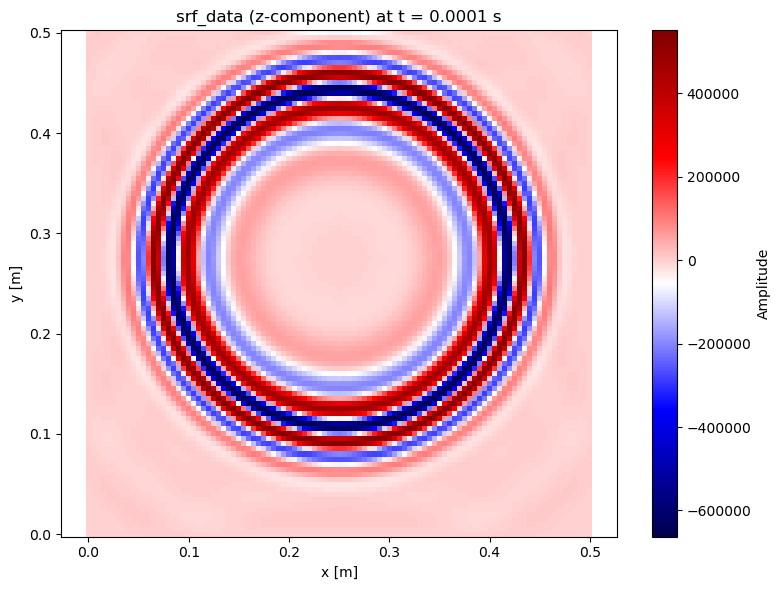

In [17]:

# Time step and component selection
t_idx = 100
comp_idx = 2  # z-component

# Extract the 2D snapshot: shape (x, y)
snapshot = data[t_idx, :, :]  # shape (101, 101)

# Create meshgrid for plotting
X, Y = np.meshgrid(x, y, indexing='ij')  # match (x, y) layout with data

# Plot snapshot
plt.figure(figsize=(8, 6))
plt.pcolormesh(X, Y, snapshot, shading='auto', cmap='seismic')
plt.colorbar(label='Amplitude')
plt.title(f"{label} (z-component) at t = {t_idx * dt:.4f} s")
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [41]:
np.shape(data)

(13335, 3, 101, 101)

In [ ]:
# SIMULATE DEFECT A

p.simulations.launch(
    simulation_configuration=SIM_NAME_DEFECT_A,
    events=p.events.list(),
    site_name=SALVUS_FLOW_SITE_NAME,
    ranks_per_job=4,
    # extra_output_configuration={
    #     "surface_data": {
    #         "sampling_interval_in_time_steps": sb,
    #         "fields": ["velocity"],
    #         "side_sets": ["z1"],
    #     },
    # },
)

[2025-05-28 14:47:56,785] INFO: Submitting job array with 5 jobs ...


Initializing Jobs and Uploading Files for Individual Jobs:   0%|          | 0/5 [00:00<?, ?job/s]

VBox()

True

In [ ]:
p.simulations.query(block=True)

In [29]:

# Assuming these are already defined:
# - PROJECT_DIR
# - SIM_NAME_DEFECT_A
# - p (your simulation project handle)
# - src_all (coordinates of receivers)
# - dt (time step)

# Create output folder
folder_name = os.path.join(PROJECT_DIR, SIM_NAME_DEFECT_A, "ReceiverData")
os.makedirs(folder_name, exist_ok=True)
print(f"Folder '{folder_name}' created successfully!")

# Get all relevant waveform entries
ed = p.waveforms.get("fz_defect_A", p.events.list())

# Loop over each source event (SRC 01 to SRC 05)
for i, SrcEvent in enumerate(ed):
    try:
        times, values = SrcEvent.get_data_cube(receiver_field="velocity", component="Z")
        
        # Construct the filename for each source
        savename = f"{SIM_NAME_DEFECT_A}_SrcEvent{i+1:02d}.h5"
        savepath = os.path.join(folder_name, savename)
        
        # Save in MATLAB v7.3-compatible HDF5 format
        with h5py.File(savepath, 'w') as f:
            f.create_dataset('data', data=values)                # NxT array
            f.create_dataset('x', data=src_all[:, 0])            # Receiver X-coordinates
            f.create_dataset('y', data=src_all[:, 1])            # Receiver Y-coordinates
            f.create_dataset('z', data=src_all[:, 2])            # Receiver Y-coordinates
            f.create_dataset('time', data=times)          # Scalar as array
            f.create_dataset('label', data=np.string_('rec_data'))  # String

        print(f"Written: {savename}")
    
    except Exception as e:
        print(f"Skipping SrcEvent{i+1:02d} due to error: {e}")

Folder 'alu_plate_9mm_50x50cm_T10ms_Ricker_fc50kHz_Q_250/fz_defect_A/ReceiverData' created successfully!
Written: fz_defect_A_SrcEvent01.h5
Written: fz_defect_A_SrcEvent02.h5
Written: fz_defect_A_SrcEvent03.h5
Written: fz_defect_A_SrcEvent04.h5
Written: fz_defect_A_SrcEvent05.h5


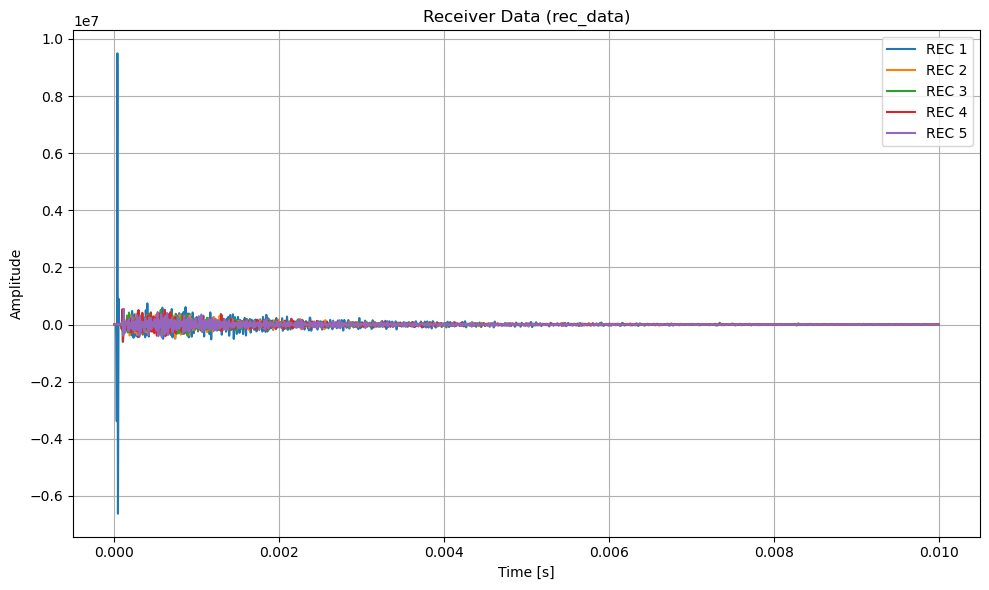

In [20]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Path to one of your saved files (update if needed)
load_path = 'alu_plate_9mm_50x50cm_T10ms_Ricker_fc50kHz_Q_250/fz_defect_A/ReceiverData/fz_defect_A_SrcEvent01.h5'

# Load the HDF5 file
with h5py.File(load_path, 'r') as f:
    data = f['data'][:]        # Shape: (num_receivers, num_time_steps)
    t = f['time'][:]            # Extract scalar time step
    try:
        label = f['label'][()].decode()  # Optional, for verification
    except:
        label = None

# Create time axis
# num_time_steps = data.shape[1]
times = t

# Plot all receiver traces
plt.figure(figsize=(10, 6))
for i in range(data.shape[0]):
    plt.plot(times, data[i, :], label=f'REC {i+1}')

plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title(f'Receiver Data ({label})' if label else 'Receiver Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
np.shape(data)

(5, 80001)

In [31]:
# SIMULATE DEFECT B

p.simulations.launch(
    simulation_configuration=SIM_NAME_DEFECT_B,
    events=p.events.list(),
    site_name=SALVUS_FLOW_SITE_NAME,
    ranks_per_job=4,
    # extra_output_configuration={
    #     "surface_data": {
    #         "sampling_interval_in_time_steps": sb,
    #         "fields": ["velocity"],
    #         "side_sets": ["z1"],
    #     },
    # },
)

[2025-05-28 15:35:05,925] INFO: Submitting job array with 5 jobs ...


Initializing Jobs and Uploading Files for Individual Jobs:   0%|          | 0/5 [00:00<?, ?job/s]

5

In [32]:
p.simulations.query(block=True)

VBox()

True

In [33]:
# Create output folder
folder_name = os.path.join(PROJECT_DIR, SIM_NAME_DEFECT_B, "ReceiverData")
os.makedirs(folder_name, exist_ok=True)
print(f"Folder '{folder_name}' created successfully!")

# Get all relevant waveform entries
ed = p.waveforms.get("fz_defect_B", p.events.list())

# Loop over each source event (SRC 01 to SRC 05)
for i, SrcEvent in enumerate(ed):
    try:
        times, values = SrcEvent.get_data_cube(receiver_field="velocity", component="Z")
        
        # Construct the filename for each source
        savename = f"{SIM_NAME_DEFECT_B}_SrcEvent{i+1:02d}.h5"
        savepath = os.path.join(folder_name, savename)
        
        # Save in MATLAB v7.3-compatible HDF5 format
        with h5py.File(savepath, 'w') as f:
            f.create_dataset('data', data=values)                # NxT array
            f.create_dataset('x', data=src_all[:, 0])            # Receiver X-coordinates
            f.create_dataset('y', data=src_all[:, 1])            # Receiver Y-coordinates
            f.create_dataset('z', data=src_all[:, 2])            # Receiver Y-coordinates
            f.create_dataset('time', data=times)          # Scalar as array
            f.create_dataset('label', data=np.string_('rec_data'))  # String

        print(f"Written: {savename}")
    
    except Exception as e:
        print(f"Skipping SrcEvent{i+1:02d} due to error: {e}")

Folder 'alu_plate_9mm_50x50cm_T10ms_Ricker_fc50kHz_Q_250/fz_defect_B/ReceiverData' created successfully!
Written: fz_defect_B_SrcEvent01.h5
Written: fz_defect_B_SrcEvent02.h5
Written: fz_defect_B_SrcEvent03.h5
Written: fz_defect_B_SrcEvent04.h5
Written: fz_defect_B_SrcEvent05.h5


In [34]:
# SIMULATE DEFECT C

p.simulations.launch(
    simulation_configuration=SIM_NAME_DEFECT_C,
    events=p.events.list(),
    site_name=SALVUS_FLOW_SITE_NAME,
    ranks_per_job=4,
    # extra_output_configuration={
    #     "surface_data": {
    #         "sampling_interval_in_time_steps": sb,
    #         "fields": ["velocity"],
    #         "side_sets": ["z1"],
    #     },
    # },
)

[2025-05-28 16:22:49,922] INFO: Submitting job array with 5 jobs ...


Initializing Jobs and Uploading Files for Individual Jobs:   0%|          | 0/5 [00:00<?, ?job/s]

5

In [35]:
p.simulations.query(block=True)

VBox()

True

In [36]:
# Create output folder
folder_name = os.path.join(PROJECT_DIR, SIM_NAME_DEFECT_C, "ReceiverData")
os.makedirs(folder_name, exist_ok=True)
print(f"Folder '{folder_name}' created successfully!")

# Get all relevant waveform entries
ed = p.waveforms.get("fz_defect_C", p.events.list())

# Loop over each source event (SRC 01 to SRC 05)
for i, SrcEvent in enumerate(ed):
    try:
        times, values = SrcEvent.get_data_cube(receiver_field="velocity", component="Z")
        
        # Construct the filename for each source
        savename = f"{SIM_NAME_DEFECT_C}_SrcEvent{i+1:02d}.h5"
        savepath = os.path.join(folder_name, savename)
        
        # Save in MATLAB v7.3-compatible HDF5 format
        with h5py.File(savepath, 'w') as f:
            f.create_dataset('data', data=values)                # NxT array
            f.create_dataset('x', data=src_all[:, 0])            # Receiver X-coordinates
            f.create_dataset('y', data=src_all[:, 1])            # Receiver Y-coordinates
            f.create_dataset('z', data=src_all[:, 2])            # Receiver Y-coordinates
            f.create_dataset('time', data=times)          # Scalar as array
            f.create_dataset('label', data=np.string_('rec_data'))  # String

        print(f"Written: {savename}")
    
    except Exception as e:
        print(f"Skipping SrcEvent{i+1:02d} due to error: {e}")

Folder 'alu_plate_9mm_50x50cm_T10ms_Ricker_fc50kHz_Q_250/fz_defect_C/ReceiverData' created successfully!
Written: fz_defect_C_SrcEvent01.h5
Written: fz_defect_C_SrcEvent02.h5
Written: fz_defect_C_SrcEvent03.h5
Written: fz_defect_C_SrcEvent04.h5
Written: fz_defect_C_SrcEvent05.h5


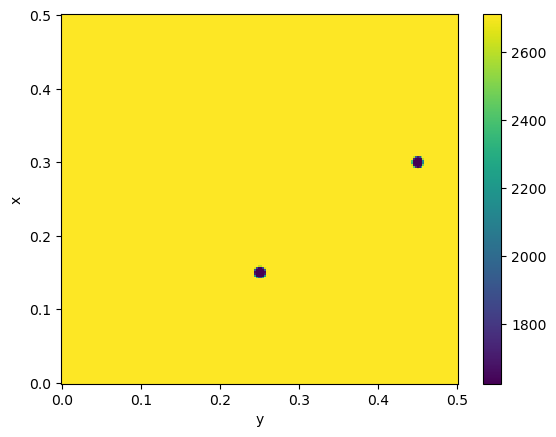

In [42]:
# Density Defect 
rho_defect = 0.2 * rho0

# DEFECT A
defect_x = 0.3 * x_max
defect_y = 0.5 * y_max

rhoA = xr.DataArray(
    data=smooth_defect_property(
        X,
        Y,
        center_x=defect_x,
        center_y=defect_y,
        size=0.015,
        taper_fraction=0.2,
        prop0=rho0,
        prop_defect=rho_defect,
    ),
    dims=["x", "y"],
    coords={"x": x, "y": y},
)

# DEFECT B
defect_x = 0.6 * x_max
defect_y = 0.9 * y_max

rhoB = xr.DataArray(
    data=smooth_defect_property(
        X,
        Y,
        center_x=defect_x,
        center_y=defect_y,
        size=0.015,
        taper_fraction=0.2,
        prop0=rho0,
        prop_defect=rho_defect,
    ),
    dims=["x", "y"],
    coords={"x": x, "y": y},
)

rhoAB = (rhoA + rhoB)/2

rhoAB.plot()

material_varying = sn.material.from_params(
    vp=vp0,
    vs=vs0,
    rho=rhoAB,
    qmu=Q,
    qkappa=Q,
)

# Because we can't attach linear solids to a material, we need to create a
# layered model with a single layer and no interfaces.
model = sn.layered_meshing.LayeredModel(
    strata=[material_varying],
    linear_solids=sn.LinearSolids(reference_frequency=fc),
)

mesh_defect_AB = sn.layered_meshing.mesh_from_domain(
    domain=d,
    model=model,
    mesh_resolution=sn.MeshResolution(
        reference_frequency=2.5 * fc,
        elements_per_wavelength=2.0,
        model_order=4,
    ),
)


In [44]:
# DEFECT A + B SIM
SIM_NAME_DEFECT_AB = "fz_defect_AB"
p.add_to_project(
    sn.UnstructuredMeshSimulationConfiguration(
        name=SIM_NAME_DEFECT_AB,
        unstructured_mesh=mesh_defect_AB,
        event_configuration=ec,
    )
)

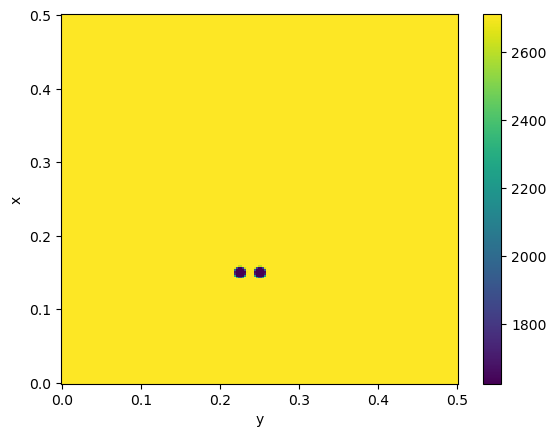

In [45]:
# Density Defect 
rho_defect = 0.2 * rho0

# DEFECT A
defect_x = 0.3 * x_max
defect_y = 0.5 * y_max

rhoA = xr.DataArray(
    data=smooth_defect_property(
        X,
        Y,
        center_x=defect_x,
        center_y=defect_y,
        size=0.015,
        taper_fraction=0.2,
        prop0=rho0,
        prop_defect=rho_defect,
    ),
    dims=["x", "y"],
    coords={"x": x, "y": y},
)

# DEFECT C
defect_x = 0.3 * x_max
defect_y = 0.45 * y_max

rhoC = xr.DataArray(
    data=smooth_defect_property(
        X,
        Y,
        center_x=defect_x,
        center_y=defect_y,
        size=0.015,
        taper_fraction=0.2,
        prop0=rho0,
        prop_defect=rho_defect,
    ),
    dims=["x", "y"],
    coords={"x": x, "y": y},
)

rhoAC = (rhoA+rhoC)/2

rhoAC.plot()

material_varying = sn.material.from_params(
    vp=vp0,
    vs=vs0,
    rho=rhoAC,
    qmu=Q,
    qkappa=Q,
)

# Because we can't attach linear solids to a material, we need to create a
# layered model with a single layer and no interfaces.
model = sn.layered_meshing.LayeredModel(
    strata=[material_varying],
    linear_solids=sn.LinearSolids(reference_frequency=fc),
)

mesh_defect_AC = sn.layered_meshing.mesh_from_domain(
    domain=d,
    model=model,
    mesh_resolution=sn.MeshResolution(
        reference_frequency=2.5 * fc,
        elements_per_wavelength=2.0,
        model_order=4,
    ),
)


In [46]:
# DEFECT A + B SIM
SIM_NAME_DEFECT_AC = "fz_defect_AC"
p.add_to_project(
    sn.UnstructuredMeshSimulationConfiguration(
        name=SIM_NAME_DEFECT_AC,
        unstructured_mesh=mesh_defect_AC,
        event_configuration=ec,
    )
)

In [30]:
p.viz.nb.simulation_setup(
    simulation_configuration=SIM_NAME_DEFECT_AC, events="fz_src01"
)

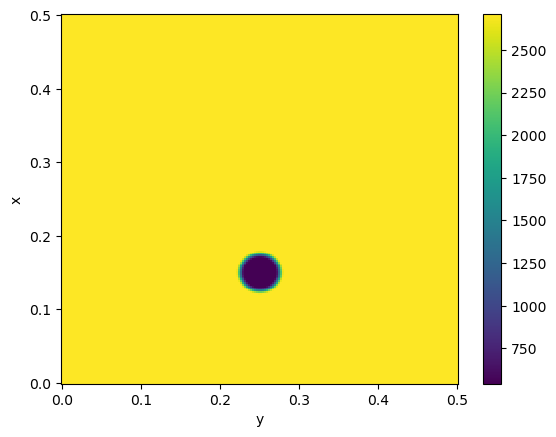

In [31]:

# Density Defect 
rho_defect = 0.2 * rho0

# DEFECT A
defect_x = 0.3 * x_max
defect_y = 0.5 * y_max

rho = xr.DataArray(
    data=smooth_defect_property(
        X,
        Y,
        center_x=defect_x,
        center_y=defect_y,
        size=0.05,
        taper_fraction=0.2,
        prop0=rho0,
        prop_defect=rho_defect,
    ),
    dims=["x", "y"],
    coords={"x": x, "y": y},
)

rho.plot()

material_varying = sn.material.from_params(
    vp=vp0,
    vs=vs0,
    rho=rho,
    qmu=Q,
    qkappa=Q,
)

# Because we can't attach linear solids to a material, we need to create a
# layered model with a single layer and no interfaces.
model = sn.layered_meshing.LayeredModel(
    strata=[material_varying],
    linear_solids=sn.LinearSolids(reference_frequency=fc),
)

mesh_defect_A5 = sn.layered_meshing.mesh_from_domain(
    domain=d,
    model=model,
    mesh_resolution=sn.MeshResolution(
        reference_frequency=2.5 * fc,
        elements_per_wavelength=2.0,
        model_order=4,
    ),
)

In [32]:
# DEFECT A + B SIM
SIM_NAME_DEFECT_A5 = "fz_defect_A5"
p.add_to_project(
    sn.UnstructuredMeshSimulationConfiguration(
        name=SIM_NAME_DEFECT_A5,
        unstructured_mesh=mesh_defect_A5,
        event_configuration=ec,
    )
)

In [47]:
p.simulations.launch(
    simulation_configuration=SIM_NAME_DEFECT_AB,
    events=p.events.list(),
    site_name=SALVUS_FLOW_SITE_NAME,
    ranks_per_job=4,
    # extra_output_configuration={
    #     "surface_data": {
    #         "sampling_interval_in_time_steps": sb,
    #         "fields": ["velocity"],
    #         "side_sets": ["z1"],
    #     },
    # },
)

[2025-06-03 12:09:41,156] INFO: Submitting job array with 5 jobs ...


Initializing Jobs and Uploading Files for Individual Jobs:   0%|          | 0/5 [00:00<?, ?job/s]

5

In [48]:
p.simulations.query(block=True)

VBox()

True

In [49]:
# Create output folder
folder_name = os.path.join(PROJECT_DIR, SIM_NAME_DEFECT_AB, "ReceiverData")
os.makedirs(folder_name, exist_ok=True)
print(f"Folder '{folder_name}' created successfully!")

# Get all relevant waveform entries
ed = p.waveforms.get("fz_defect_AB", p.events.list())

# Loop over each source event (SRC 01 to SRC 05)
for i, SrcEvent in enumerate(ed):
    try:
        times, values = SrcEvent.get_data_cube(receiver_field="velocity", component="Z")
        
        # Construct the filename for each source
        savename = f"{SIM_NAME_DEFECT_AB}_SrcEvent{i+1:02d}.h5"
        savepath = os.path.join(folder_name, savename)
        
        # Save in MATLAB v7.3-compatible HDF5 format
        with h5py.File(savepath, 'w') as f:
            f.create_dataset('data', data=values)                # NxT array
            f.create_dataset('x', data=src_all[:, 0])            # Receiver X-coordinates
            f.create_dataset('y', data=src_all[:, 1])            # Receiver Y-coordinates
            f.create_dataset('z', data=src_all[:, 2])            # Receiver Y-coordinates
            f.create_dataset('time', data=times)          # Scalar as array
            f.create_dataset('label', data=np.string_('rec_data'))  # String

        print(f"Written: {savename}")
    
    except Exception as e:
        print(f"Skipping SrcEvent{i+1:02d} due to error: {e}")

Folder 'alu_plate_9mm_50x50cm_T10ms_Ricker_fc50kHz_Q_250/fz_defect_AB/ReceiverData' created successfully!
Written: fz_defect_AB_SrcEvent01.h5
Written: fz_defect_AB_SrcEvent02.h5
Written: fz_defect_AB_SrcEvent03.h5
Written: fz_defect_AB_SrcEvent04.h5
Written: fz_defect_AB_SrcEvent05.h5


In [50]:
p.simulations.launch(
    simulation_configuration=SIM_NAME_DEFECT_AC,
    events=p.events.list(),
    site_name=SALVUS_FLOW_SITE_NAME,
    ranks_per_job=4,
    # extra_output_configuration={
    #     "surface_data": {
    #         "sampling_interval_in_time_steps": sb,
    #         "fields": ["velocity"],
    #         "side_sets": ["z1"],
    #     },
    # },
)

[2025-06-03 13:38:43,664] INFO: Submitting job array with 5 jobs ...


Initializing Jobs and Uploading Files for Individual Jobs:   0%|          | 0/5 [00:00<?, ?job/s]

5

In [51]:
p.simulations.query(block=True)

VBox()

True

In [52]:
# Create output folder
folder_name = os.path.join(PROJECT_DIR, SIM_NAME_DEFECT_AC, "ReceiverData")
os.makedirs(folder_name, exist_ok=True)
print(f"Folder '{folder_name}' created successfully!")

# Get all relevant waveform entries
ed = p.waveforms.get("fz_defect_AC", p.events.list())

# Loop over each source event (SRC 01 to SRC 05)
for i, SrcEvent in enumerate(ed):
    try:
        times, values = SrcEvent.get_data_cube(receiver_field="velocity", component="Z")
        
        # Construct the filename for each source
        savename = f"{SIM_NAME_DEFECT_AC}_SrcEvent{i+1:02d}.h5"
        savepath = os.path.join(folder_name, savename)
        
        # Save in MATLAB v7.3-compatible HDF5 format
        with h5py.File(savepath, 'w') as f:
            f.create_dataset('data', data=values)                # NxT array
            f.create_dataset('x', data=src_all[:, 0])            # Receiver X-coordinates
            f.create_dataset('y', data=src_all[:, 1])            # Receiver Y-coordinates
            f.create_dataset('z', data=src_all[:, 2])            # Receiver Y-coordinates
            f.create_dataset('time', data=times)          # Scalar as array
            f.create_dataset('label', data=np.string_('rec_data'))  # String

        print(f"Written: {savename}")
    
    except Exception as e:
        print(f"Skipping SrcEvent{i+1:02d} due to error: {e}")

Folder 'alu_plate_9mm_50x50cm_T10ms_Ricker_fc50kHz_Q_250/fz_defect_AC/ReceiverData' created successfully!
Written: fz_defect_AC_SrcEvent01.h5
Written: fz_defect_AC_SrcEvent02.h5
Written: fz_defect_AC_SrcEvent03.h5
Written: fz_defect_AC_SrcEvent04.h5
Written: fz_defect_AC_SrcEvent05.h5


In [39]:
p.simulations.launch(
    simulation_configuration=SIM_NAME_DEFECT_A5,
    events=p.events.list(),
    site_name=SALVUS_FLOW_SITE_NAME,
    ranks_per_job=4,
    # extra_output_configuration={
    #     "surface_data": {
    #         "sampling_interval_in_time_steps": sb,
    #         "fields": ["velocity"],
    #         "side_sets": ["z1"],
    #     },
    # },
)

[2025-06-02 14:35:53,764] INFO: Submitting job array with 5 jobs ...


Initializing Jobs and Uploading Files for Individual Jobs:   0%|          | 0/5 [00:00<?, ?job/s]

5

In [40]:
p.simulations.query(block=True)

VBox()

True

In [41]:
# Create output folder
folder_name = os.path.join(PROJECT_DIR, SIM_NAME_DEFECT_A5, "ReceiverData")
os.makedirs(folder_name, exist_ok=True)
print(f"Folder '{folder_name}' created successfully!")

# Get all relevant waveform entries
ed = p.waveforms.get("fz_defect_A5", p.events.list())

# Loop over each source event (SRC 01 to SRC 05)
for i, SrcEvent in enumerate(ed):
    try:
        times, values = SrcEvent.get_data_cube(receiver_field="velocity", component="Z")
        
        # Construct the filename for each source
        savename = f"{SIM_NAME_DEFECT_A5}_SrcEvent{i+1:02d}.h5"
        savepath = os.path.join(folder_name, savename)
        
        # Save in MATLAB v7.3-compatible HDF5 format
        with h5py.File(savepath, 'w') as f:
            f.create_dataset('data', data=values)                # NxT array
            f.create_dataset('x', data=src_all[:, 0])            # Receiver X-coordinates
            f.create_dataset('y', data=src_all[:, 1])            # Receiver Y-coordinates
            f.create_dataset('z', data=src_all[:, 2])            # Receiver Y-coordinates
            f.create_dataset('time', data=times)          # Scalar as array
            f.create_dataset('label', data=np.string_('rec_data'))  # String

        print(f"Written: {savename}")
    
    except Exception as e:
        print(f"Skipping SrcEvent{i+1:02d} due to error: {e}")

Folder 'alu_plate_9mm_50x50cm_T10ms_Ricker_fc50kHz_Q_250/fz_defect_A5/ReceiverData' created successfully!
Written: fz_defect_A5_SrcEvent01.h5
Written: fz_defect_A5_SrcEvent02.h5
Written: fz_defect_A5_SrcEvent03.h5
Written: fz_defect_A5_SrcEvent04.h5
Written: fz_defect_A5_SrcEvent05.h5


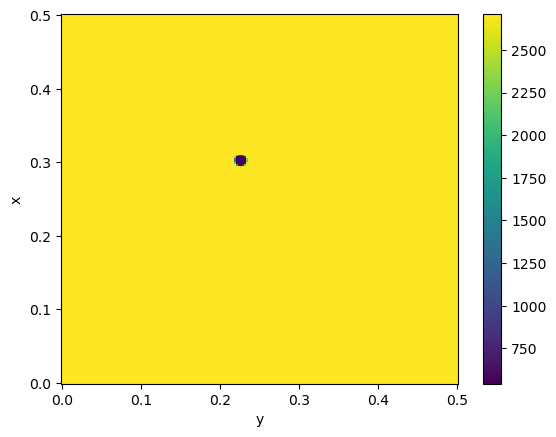

In [24]:
import xarray as xr
# Density Defect 
rho_defect = 0.2 * rho0

# DEFECT A
defect_x = 0.605 * x_max
defect_y = 0.4515 * y_max

rho = xr.DataArray(
    data=smooth_defect_property(
        X,
        Y,
        center_x=defect_x,
        center_y=defect_y,
        size=0.015,
        taper_fraction=0.2,
        prop0=rho0,
        prop_defect=rho_defect,
    ),
    dims=["x", "y"],
    coords={"x": x, "y": y},
)

rho.plot()

material_varying = sn.material.from_params(
    vp=vp0,
    vs=vs0,
    rho=rho,
    qmu=Q,
    qkappa=Q,
)

# Because we can't attach linear solids to a material, we need to create a
# layered model with a single layer and no interfaces.
model = sn.layered_meshing.LayeredModel(
    strata=[material_varying],
    linear_solids=sn.LinearSolids(reference_frequency=fc),
)

mesh_defect_D = sn.layered_meshing.mesh_from_domain(
    domain=d,
    model=model,
    mesh_resolution=sn.MeshResolution(
        reference_frequency=2.5 * fc,
        elements_per_wavelength=2.0,
        model_order=4,
    ),
)

In [25]:
# DEFECT A + B SIM
SIM_NAME_DEFECT_D = "fz_defect_D"
p.add_to_project(
    sn.UnstructuredMeshSimulationConfiguration(
        name=SIM_NAME_DEFECT_D,
        unstructured_mesh=mesh_defect_D,
        event_configuration=ec,
    )
)

[2025-06-12 17:18:33,392] INFO: This exact entity is already part of the project. Nothing will be done. The comparison to the existing mesh was fairly expensive as it is (depending on the mesh size) a large amount of data that has to be compared. So best only add it once!


In [26]:
p.simulations.launch(
    simulation_configuration=SIM_NAME_DEFECT_D,
    events=p.events.list(),
    site_name=SALVUS_FLOW_SITE_NAME,
    ranks_per_job=4,
    # extra_output_configuration={
    #     "surface_data": {
    #         "sampling_interval_in_time_steps": sb,
    #         "fields": ["velocity"],
    #         "side_sets": ["z1"],
    #     },
    # },
)

[2025-06-12 17:18:56,948] INFO: Submitting job array with 5 jobs ...


Initializing Jobs and Uploading Files for Individual Jobs:   0%|          | 0/5 [00:00<?, ?job/s]

5

In [27]:
p.simulations.query(block=True)

VBox()

True

In [28]:
# Create output folder
folder_name = os.path.join(PROJECT_DIR, SIM_NAME_DEFECT_D, "ReceiverData")
os.makedirs(folder_name, exist_ok=True)
print(f"Folder '{folder_name}' created successfully!")

# Get all relevant waveform entries
ed = p.waveforms.get("fz_defect_D", p.events.list())

# Loop over each source event (SRC 01 to SRC 05)
for i, SrcEvent in enumerate(ed):
    try:
        times, values = SrcEvent.get_data_cube(receiver_field="velocity", component="Z")
        
        # Construct the filename for each source
        savename = f"{SIM_NAME_DEFECT_D}_SrcEvent{i+1:02d}.h5"
        savepath = os.path.join(folder_name, savename)
        
        # Save in MATLAB v7.3-compatible HDF5 format
        with h5py.File(savepath, 'w') as f:
            f.create_dataset('data', data=values)                # NxT array
            f.create_dataset('x', data=src_all[:, 0])            # Receiver X-coordinates
            f.create_dataset('y', data=src_all[:, 1])            # Receiver Y-coordinates
            f.create_dataset('z', data=src_all[:, 2])            # Receiver Y-coordinates
            f.create_dataset('time', data=times)          # Scalar as array
            f.create_dataset('label', data=np.string_('rec_data'))  # String

        print(f"Written: {savename}")
    
    except Exception as e:
        print(f"Skipping SrcEvent{i+1:02d} due to error: {e}")

Folder 'alu_plate_9mm_50x50cm_T10ms_Ricker_fc50kHz_Q_250/fz_defect_D/ReceiverData' created successfully!
Written: fz_defect_D_SrcEvent01.h5
Written: fz_defect_D_SrcEvent02.h5
Written: fz_defect_D_SrcEvent03.h5
Written: fz_defect_D_SrcEvent04.h5
Written: fz_defect_D_SrcEvent05.h5


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


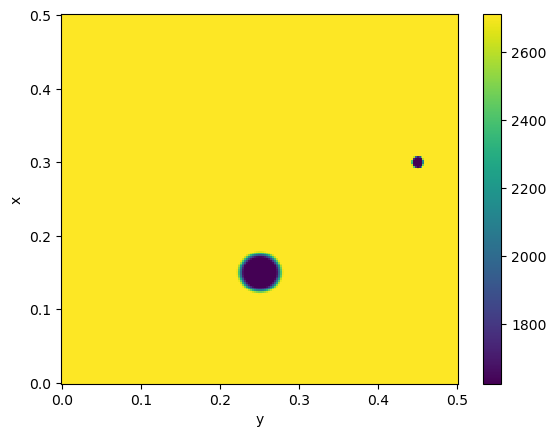

In [61]:
# Density Defect 
rho_defect = 0.2 * rho0

# DEFECT A5
defect_x = 0.3 * x_max
defect_y = 0.5 * y_max

rhoA5 = xr.DataArray(
    data=smooth_defect_property(
        X,
        Y,
        center_x=defect_x,
        center_y=defect_y,
        size=0.05,
        taper_fraction=0.2,
        prop0=rho0,
        prop_defect=rho_defect,
    ),
    dims=["x", "y"],
    coords={"x": x, "y": y},
)


# DEFECT B
defect_x = 0.6 * x_max
defect_y = 0.9 * y_max

rhoB= xr.DataArray(
    data=smooth_defect_property(
        X,
        Y,
        center_x=defect_x,
        center_y=defect_y,
        size=0.015,
        taper_fraction=0.2,
        prop0=rho0,
        prop_defect=rho_defect,
    ),
    dims=["x", "y"],
    coords={"x": x, "y": y},
)

rhoA5B = (rhoA5+rhoB)/2

rhoA5B.plot()

material_varying = sn.material.from_params(
    vp=vp0,
    vs=vs0,
    rho=rhoA5B,
    qmu=Q,
    qkappa=Q,
)

# Because we can't attach linear solids to a material, we need to create a
# layered model with a single layer and no interfaces.
model = sn.layered_meshing.LayeredModel(
    strata=[material_varying],
    linear_solids=sn.LinearSolids(reference_frequency=fc),
)

mesh_defect_A5B = sn.layered_meshing.mesh_from_domain(
    domain=d,
    model=model,
    mesh_resolution=sn.MeshResolution(
        reference_frequency=2.5 * fc,
        elements_per_wavelength=2.0,
        model_order=4,
    ),
)


In [62]:
# DEFECT A + B SIM
SIM_NAME_DEFECT_A5B = "fz_defect_A5B"
p.add_to_project(
    sn.UnstructuredMeshSimulationConfiguration(
        name=SIM_NAME_DEFECT_A5B,
        unstructured_mesh=mesh_defect_A5B,
        event_configuration=ec,
    )
)

[2025-06-12 21:10:20,967] INFO: This exact entity is already part of the project. Nothing will be done. The comparison to the existing mesh was fairly expensive as it is (depending on the mesh size) a large amount of data that has to be compared. So best only add it once!


In [63]:
p.simulations.launch(
    simulation_configuration=SIM_NAME_DEFECT_A5B,
    events=p.events.list(),
    site_name=SALVUS_FLOW_SITE_NAME,
    ranks_per_job=4,
    # extra_output_configuration={
    #     "surface_data": {
    #         "sampling_interval_in_time_steps": sb,
    #         "fields": ["velocity"],
    #         "side_sets": ["z1"],
    #     },
    # },
)

[2025-06-12 21:10:46,213] INFO: Submitting job array with 5 jobs ...


Initializing Jobs and Uploading Files for Individual Jobs:   0%|          | 0/5 [00:00<?, ?job/s]

5

In [64]:
p.simulations.query(block=True)

VBox()

True

In [65]:
# Create output folder
folder_name = os.path.join(PROJECT_DIR, SIM_NAME_DEFECT_A5B, "ReceiverData")
os.makedirs(folder_name, exist_ok=True)
print(f"Folder '{folder_name}' created successfully!")

# Get all relevant waveform entries
ed = p.waveforms.get("fz_defect_A5B", p.events.list())

# Loop over each source event (SRC 01 to SRC 05)
for i, SrcEvent in enumerate(ed):
    try:
        times, values = SrcEvent.get_data_cube(receiver_field="velocity", component="Z")
        
        # Construct the filename for each source
        savename = f"{SIM_NAME_DEFECT_A5B}_SrcEvent{i+1:02d}.h5"
        savepath = os.path.join(folder_name, savename)
        
        # Save in MATLAB v7.3-compatible HDF5 format
        with h5py.File(savepath, 'w') as f:
            f.create_dataset('data', data=values)                # NxT array
            f.create_dataset('x', data=src_all[:, 0])            # Receiver X-coordinates
            f.create_dataset('y', data=src_all[:, 1])            # Receiver Y-coordinates
            f.create_dataset('z', data=src_all[:, 2])            # Receiver Y-coordinates
            f.create_dataset('time', data=times)          # Scalar as array
            f.create_dataset('label', data=np.string_('rec_data'))  # String

        print(f"Written: {savename}")
    
    except Exception as e:
        print(f"Skipping SrcEvent{i+1:02d} due to error: {e}")

Folder 'alu_plate_9mm_50x50cm_T10ms_Ricker_fc50kHz_Q_250/fz_defect_A5B/ReceiverData' created successfully!
Written: fz_defect_A5B_SrcEvent01.h5
Written: fz_defect_A5B_SrcEvent02.h5
Written: fz_defect_A5B_SrcEvent03.h5
Written: fz_defect_A5B_SrcEvent04.h5
Written: fz_defect_A5B_SrcEvent05.h5


In [ ]:
# ETH SIGN

defect_x = 0.3 * x_max
defect_y = 0.5 * y_max

centroids = mesh_homo.get_element_centroid()

centroids_x, centroids_y, centroids_z = centroids.T

# Find centroid closest to defect

defect_element_id = np.argmin(
    np.sqrt((centroids_x - defect_x) ** 2 + (centroids_y - defect_y) ** 2)
)

# Create a new mesh for discrete defects
mesh_discrete_1_element = mesh_homo.copy()
# mesh_discrete_N_elements = mesh_homo.copy()

density_mesh_1_element = mesh_homo.elemental_fields["RHO"].copy()
# density_mesh_N_elements = mesh_homo.elemental_fields["RHO"].copy()

density_mesh_1_element[:] = rho0
density_mesh_1_element[
    defect_element_id,  # The first dimension is element ID
    # The second dimension is GLL id, but since we want discrete defects, we
    # set all GLLs to the same value
    :,
] = rho_defect

# density_mesh_N_elements[:] = rho0
# density_mesh_N_elements[defect_element_ids, :] = rho_defect

mesh_discrete_1_element.elemental_fields["RHO"] = density_mesh_1_element
# mesh_discrete_N_elements.elemental_fields["RHO"] = density_mesh_N_elements

mesh_discrete_1_element

In [18]:
# Original ETH letter coordinates in normalized form
eth_coords_normalized = [
    # E
    (0.20, 0.38), (0.20, 0.44), (0.20, 0.50), (0.20, 0.56), (0.20, 0.62),
    (0.26, 0.62), (0.26, 0.50), (0.26, 0.38),
    (0.32, 0.62), (0.32, 0.38),
    
    # T
    (0.44, 0.62), (0.50, 0.62), (0.56, 0.62),
    (0.50, 0.56), (0.50, 0.50), (0.50, 0.44), (0.50, 0.38),
    
    # H
    (0.68, 0.38), (0.68, 0.44), (0.68, 0.50), (0.68, 0.56), (0.68, 0.62),
    (0.74, 0.50),
    (0.80, 0.38), (0.80, 0.44), (0.80, 0.50), (0.80, 0.56), (0.80, 0.62)
]

# Scale coordinates to match actual domain size
eth_coords = [(x * x_max, y * y_max) for (x, y) in eth_coords_normalized]

# Apply scaling and y-shift
eth_coords = [(x * x_max, y * y_max - 0.06) for (x, y) in eth_coords_normalized]

# Unpack centroids from mesh
centroids = mesh_homo.get_element_centroid()
centroids_x, centroids_y, centroids_z = centroids.T

# Collect the element indices closest to each coordinate in eth_coords
defect_element_ids = []
for x_target, y_target in eth_coords:
    element_id = np.argmin(
        np.sqrt((centroids_x - x_target) ** 2 + (centroids_y - y_target) ** 2)
    )
    defect_element_ids.append(element_id)

# Optionally remove duplicates
defect_element_ids = np.unique(defect_element_ids)

# Copy original mesh
mesh_discrete_N_elements = mesh_homo.copy()

# Create modified density field
density_mesh_N_elements = mesh_homo.elemental_fields["RHO"].copy()
density_mesh_N_elements[:] = rho0  # Set default density
density_mesh_N_elements[defect_element_ids, :] = 0.2*rho0  # Apply defect

# Assign to mesh
mesh_discrete_N_elements.elemental_fields["RHO"] = density_mesh_N_elements

# Return the modified mesh
mesh_discrete_N_elements

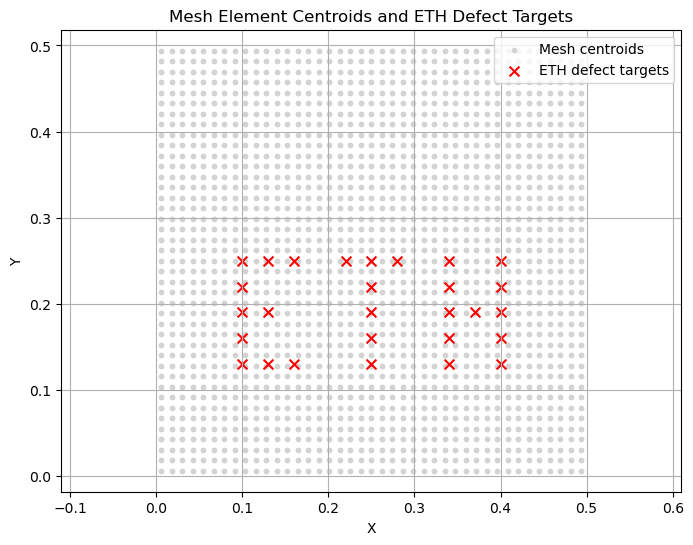

In [19]:
import matplotlib.pyplot as plt

# Plot centroids of all elements
plt.figure(figsize=(8, 6))
plt.scatter(centroids_x, centroids_y, s=10, c='lightgray', label='Mesh centroids')

# Overlay the ETH defect target locations
eth_x, eth_y = zip(*eth_coords)  # Unpack into separate x and y lists
plt.scatter(eth_x, eth_y, s=50, c='red', marker='x', label='ETH defect targets')

# Formatting
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Mesh Element Centroids and ETH Defect Targets")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()

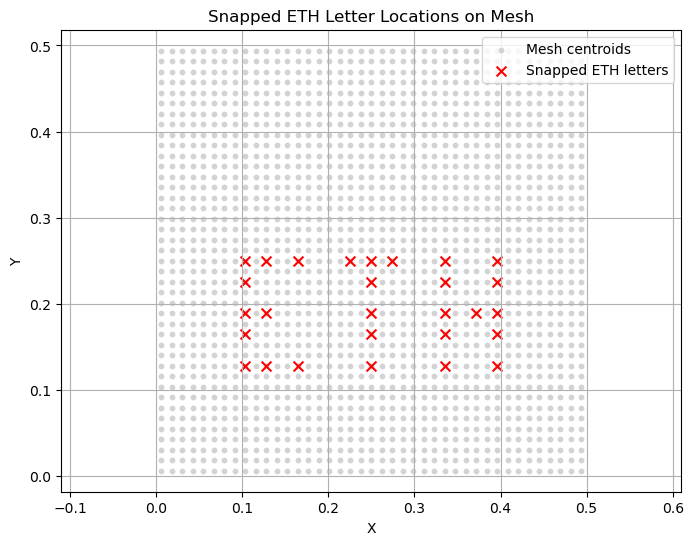

In [55]:
import numpy as np

# Convert centroids to 2D array
centroids_xy = np.column_stack((centroids_x, centroids_y))

# Snap eth_coords to the closest mesh centroid
snapped_eth_coords = []
for x_target, y_target in eth_coords:
    distances = np.sqrt((centroids_x - x_target) ** 2 + (centroids_y - y_target) ** 2)
    closest_index = np.argmin(distances)
    snapped_point = (centroids_x[closest_index], centroids_y[closest_index])
    snapped_eth_coords.append(snapped_point)

plt.figure(figsize=(8, 6))
plt.scatter(centroids_x, centroids_y, s=10, c='lightgray', label='Mesh centroids')

eth_x, eth_y = zip(*snapped_eth_coords)
plt.scatter(eth_x, eth_y, s=50, c='red', marker='x', label='Snapped ETH letters')

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Snapped ETH Letter Locations on Mesh")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()

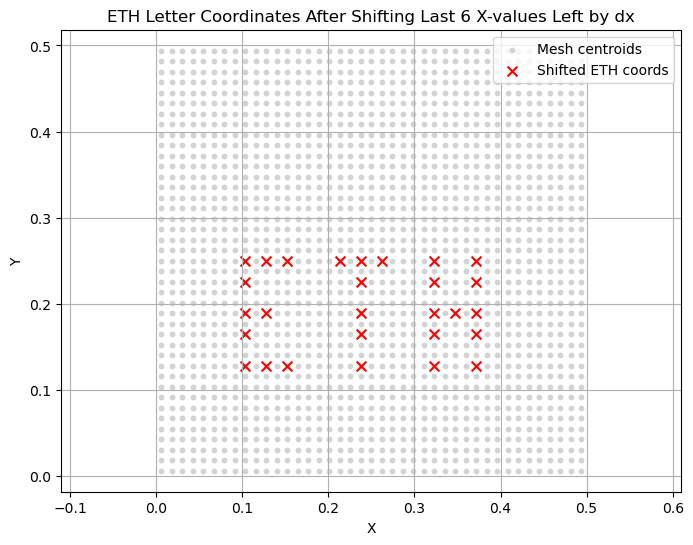

In [56]:
# Estimate dx from sorted unique x-values of centroids
unique_x = np.unique(np.round(centroids_x, decimals=8))
unique_x.sort()
dx = np.min(np.diff(unique_x))  # Smallest spacing

snapped_eth_coords = np.array(snapped_eth_coords)

snapped_eth_coords[[8, 9], 0] -= dx
snapped_eth_coords[-6:, 0] -= dx  # Shift last 6 x-values left by dx
snapped_eth_coords[10:, 0] -= dx  # Shift last 6 x-values left by dx

plt.figure(figsize=(8, 6))
plt.scatter(centroids_x, centroids_y, s=10, c='lightgray', label='Mesh centroids')
plt.scatter(*snapped_eth_coords.T, s=50, c='red', marker='x', label='Shifted ETH coords')

plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.title("ETH Letter Coordinates After Shifting Last 6 X-values Left by dx")
plt.show()

In [66]:
eth_coords = snapped_eth_coords

# Unpack centroids from mesh
centroids = mesh_homo.get_element_centroid()
centroids_x, centroids_y, centroids_z = centroids.T

# Collect the element indices closest to each coordinate in eth_coords
defect_element_ids = []
for x_target, y_target in eth_coords:
    element_id = np.argmin(
        np.sqrt((centroids_x - x_target) ** 2 + (centroids_y - y_target) ** 2)
    )
    defect_element_ids.append(element_id)

# Optionally remove duplicates
defect_element_ids = np.unique(defect_element_ids)

# Copy original mesh
mesh_discrete_N_elements = mesh_homo.copy()

# Create modified density field
density_mesh_N_elements = mesh_homo.elemental_fields["RHO"].copy()
density_mesh_N_elements[:] = rho0  # Set default density
density_mesh_N_elements[defect_element_ids, :] = 0.2*rho0  # Apply defect

# Assign to mesh
mesh_discrete_N_elements.elemental_fields["RHO"] = density_mesh_N_elements

# Return the modified mesh
mesh_discrete_N_elements

In [67]:
# DEFECT A + B SIM
SIM_NAME_DEFECT_ETH = "fz_defect_ETH"
p.add_to_project(
    sn.UnstructuredMeshSimulationConfiguration(
        name=SIM_NAME_DEFECT_ETH,
        unstructured_mesh=mesh_discrete_N_elements,
        event_configuration=ec,
    )
)

In [68]:
p.simulations.launch(
    simulation_configuration=SIM_NAME_DEFECT_ETH,
    events=p.events.list(),
    site_name=SALVUS_FLOW_SITE_NAME,
    ranks_per_job=4,
    # extra_output_configuration={
    #     "surface_data": {
    #         "sampling_interval_in_time_steps": sb,
    #         "fields": ["velocity"],
    #         "side_sets": ["z1"],
    #     },
    # },
)

[2025-06-12 22:33:46,364] INFO: Submitting job array with 5 jobs ...


Initializing Jobs and Uploading Files for Individual Jobs:   0%|          | 0/5 [00:00<?, ?job/s]

5

In [69]:
p.simulations.query(block=True)

VBox()

True

In [70]:
# Create output folder
folder_name = os.path.join(PROJECT_DIR, SIM_NAME_DEFECT_ETH, "ReceiverData")
os.makedirs(folder_name, exist_ok=True)
print(f"Folder '{folder_name}' created successfully!")

# Get all relevant waveform entries
ed = p.waveforms.get("fz_defect_ETH", p.events.list())

# Loop over each source event (SRC 01 to SRC 05)
for i, SrcEvent in enumerate(ed):
    try:
        times, values = SrcEvent.get_data_cube(receiver_field="velocity", component="Z")
        
        # Construct the filename for each source
        savename = f"{SIM_NAME_DEFECT_ETH}_SrcEvent{i+1:02d}.h5"
        savepath = os.path.join(folder_name, savename)
        
        # Save in MATLAB v7.3-compatible HDF5 format
        with h5py.File(savepath, 'w') as f:
            f.create_dataset('data', data=values)                # NxT array
            f.create_dataset('x', data=src_all[:, 0])            # Receiver X-coordinates
            f.create_dataset('y', data=src_all[:, 1])            # Receiver Y-coordinates
            f.create_dataset('z', data=src_all[:, 2])            # Receiver Y-coordinates
            f.create_dataset('time', data=times)          # Scalar as array
            f.create_dataset('label', data=np.string_('rec_data'))  # String

        print(f"Written: {savename}")
    
    except Exception as e:
        print(f"Skipping SrcEvent{i+1:02d} due to error: {e}")

Folder 'alu_plate_9mm_50x50cm_T10ms_Ricker_fc50kHz_Q_250/fz_defect_ETH/ReceiverData' created successfully!
Written: fz_defect_ETH_SrcEvent01.h5
Written: fz_defect_ETH_SrcEvent02.h5
Written: fz_defect_ETH_SrcEvent03.h5
Written: fz_defect_ETH_SrcEvent04.h5
Written: fz_defect_ETH_SrcEvent05.h5


In [14]:
defect_x = 0.6 * x_max
defect_y = 0.5 * y_max

centroids = mesh_homo.get_element_centroid()

centroids_x, centroids_y, centroids_z = centroids.T

# Also find all elements a distance of D from the defect
D = 0.05
defect_element_ids = np.where(
    np.sqrt((centroids_x - defect_x) ** 2 + (centroids_y - defect_y) ** 2) < D
)[0]


# Create a new mesh for discrete defects
mesh_discrete_N_elements = mesh_homo.copy()

density_mesh_N_elements = mesh_homo.elemental_fields["RHO"].copy()

density_mesh_N_elements[:] = rho0
density_mesh_N_elements[defect_element_ids, :] = 0.2*rho0

mesh_discrete_N_elements.elemental_fields["RHO"] = density_mesh_N_elements

mesh_discrete_N_elements

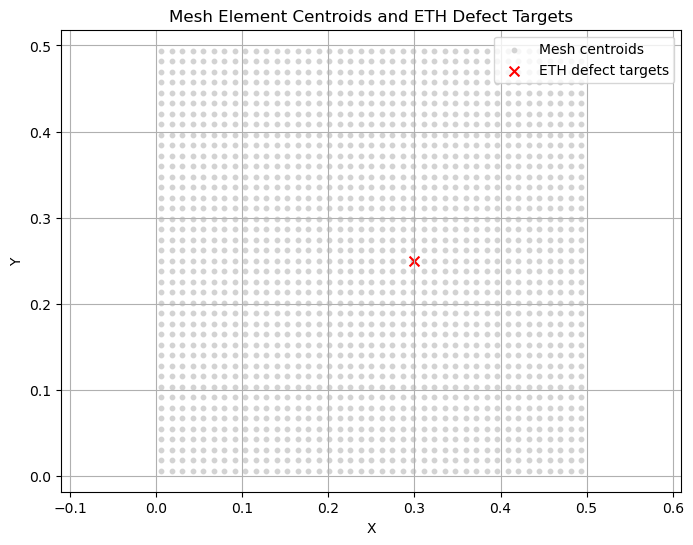

In [15]:
import matplotlib.pyplot as plt

# Plot centroids of all elements
plt.figure(figsize=(8, 6))
plt.scatter(centroids_x, centroids_y, s=10, c='lightgray', label='Mesh centroids')

# Overlay the ETH defect target locations
# eth_x, eth_y = zip(*eth_coords)  # Unpack into separate x and y lists
plt.scatter(defect_x, defect_y, s=50, c='red', marker='x', label='ETH defect targets')

# Formatting
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Mesh Element Centroids and ETH Defect Targets")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()

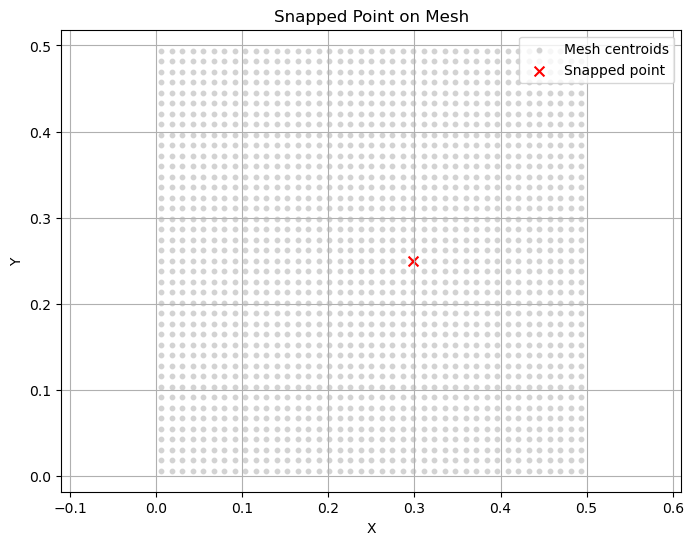

In [17]:
# Convert centroids to 2D array
centroids_xy = np.column_stack((centroids_x, centroids_y))

# Single defect point
defect = np.array([defect_x, defect_y])
x_target, y_target = defect

# Compute distance to all centroids
distances = np.sqrt((centroids_x - x_target) ** 2 + (centroids_y - y_target) ** 2)
closest_index = np.argmin(distances)

# Get snapped point
snapped_point = (centroids_x[closest_index], centroids_y[closest_index])

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(centroids_x, centroids_y, s=10, c='lightgray', label='Mesh centroids')
plt.scatter(*snapped_point, s=50, c='red', marker='x', label='Snapped point')

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Snapped Point on Mesh")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()

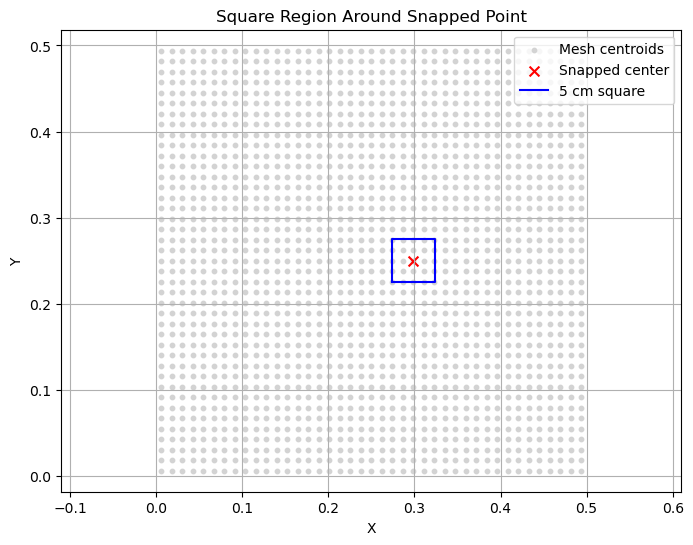

In [18]:
# Snapped center point
x_center, y_center = snapped_point

# Half side length of the square (5 cm side → 2.5 cm = 0.025 m half-side)
half_side = 0.025

# Define the square corners (in clockwise or counter-clockwise order)
square_corners = [
    (x_center - half_side, y_center - half_side),  # bottom left
    (x_center - half_side, y_center + half_side),  # top left
    (x_center + half_side, y_center + half_side),  # top right
    (x_center + half_side, y_center - half_side),  # bottom right
    (x_center - half_side, y_center - half_side),  # close the square
]

# Unzip square corners for plotting
square_x, square_y = zip(*square_corners)

plt.figure(figsize=(8, 6))
plt.scatter(centroids_x, centroids_y, s=10, c='lightgray', label='Mesh centroids')
plt.scatter(x_center, y_center, s=50, c='red', marker='x', label='Snapped center')
plt.plot(square_x, square_y, 'b-', label='5 cm square')

plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.legend()
plt.grid(True)
plt.title("Square Region Around Snapped Point")
plt.show()

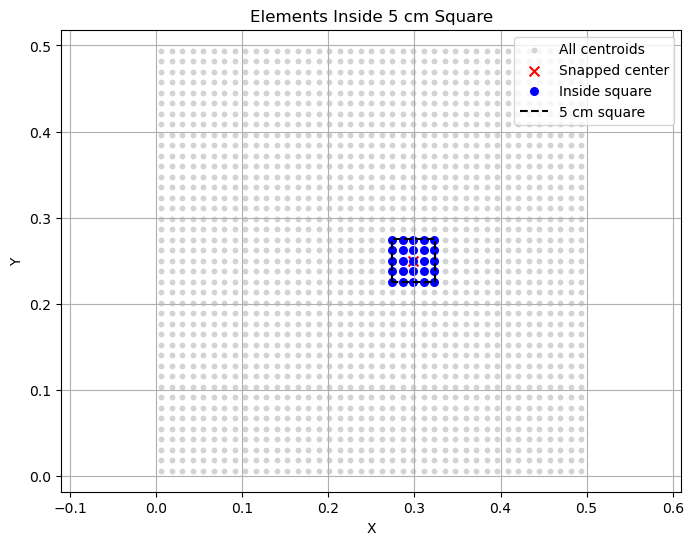

In [19]:
half_side = 0.025  # 5 cm side → 2.5 cm half-side

x_min = x_center - half_side
x_max = x_center + half_side
y_min = y_center - half_side
y_max = y_center + half_side

inside_square_mask = (
    (centroids_x >= x_min) & (centroids_x <= x_max) &
    (centroids_y >= y_min) & (centroids_y <= y_max)
)

# Get the indices of the elements inside or on the square
square_element_ids = np.where(inside_square_mask)[0]

snapped_coords = np.column_stack((centroids_x[square_element_ids], centroids_y[square_element_ids]))

plt.figure(figsize=(8, 6))
plt.scatter(centroids_x, centroids_y, s=10, c='lightgray', label='All centroids')
plt.scatter(x_center, y_center, s=50, c='red', marker='x', label='Snapped center')
plt.scatter(*snapped_coords.T, s=30, c='blue', label='Inside square')
plt.plot(
    [x_min, x_min, x_max, x_max, x_min],
    [y_min, y_max, y_max, y_min, y_min],
    'k--', label='5 cm square'
)

plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.legend()
plt.grid(True)
plt.title("Elements Inside 5 cm Square")
plt.show()

In [20]:
coords = snapped_coords

# Unpack centroids from mesh
centroids = mesh_homo.get_element_centroid()
centroids_x, centroids_y, centroids_z = centroids.T

# Collect the element indices closest to each coordinate in eth_coords
defect_element_ids = []
for x_target, y_target in coords:
    element_id = np.argmin(
        np.sqrt((centroids_x - x_target) ** 2 + (centroids_y - y_target) ** 2)
    )
    defect_element_ids.append(element_id)

# Optionally remove duplicates
defect_element_ids = np.unique(defect_element_ids)

# Copy original mesh
mesh_discrete_N_elements = mesh_homo.copy()

# Create modified density field
density_mesh_N_elements = mesh_homo.elemental_fields["RHO"].copy()
density_mesh_N_elements[:] = rho0  # Set default density
density_mesh_N_elements[defect_element_ids, :] = 0.2*rho0  # Apply defect

# Assign to mesh
mesh_discrete_N_elements.elemental_fields["RHO"] = density_mesh_N_elements

# Return the modified mesh
mesh_discrete_N_elements

In [21]:
# DEFECT A + B SIM
SIM_NAME_DEFECT_E = "fz_defect_E"
p.add_to_project(
    sn.UnstructuredMeshSimulationConfiguration(
        name=SIM_NAME_DEFECT_E,
        unstructured_mesh=mesh_discrete_N_elements,
        event_configuration=ec,
    )
)

In [ ]:

p.simulations.launch(
    simulation_configuration=SIM_NAME_DEFECT_E,
    events=p.events.list(),
    site_name=SALVUS_FLOW_SITE_NAME,
    ranks_per_job=4,
    # extra_output_configuration={
    #     "surface_data": {
    #         "sampling_interval_in_time_steps": sb,
    #         "fields": ["velocity"],
    #         "side_sets": ["z1"],
    #     },
    # },
)

[2025-06-13 10:06:56,873] INFO: Submitting job array with 5 jobs ...


Initializing Jobs and Uploading Files for Individual Jobs:   0%|          | 0/5 [00:00<?, ?job/s]

5

In [23]:
p.simulations.query(block=True)

VBox()

True

In [28]:
# Create output folder
folder_name = os.path.join(PROJECT_DIR, SIM_NAME_DEFECT_E, "ReceiverData")
os.makedirs(folder_name, exist_ok=True)
print(f"Folder '{folder_name}' created successfully!")

# Get all relevant waveform entries
ed = p.waveforms.get("fz_defect_E", p.events.list())

# Loop over each source event (SRC 01 to SRC 05)
for i, SrcEvent in enumerate(ed):
    try:
        times, values = SrcEvent.get_data_cube(receiver_field="velocity", component="Z")
        
        # Construct the filename for each source
        savename = f"{SIM_NAME_DEFECT_E}_SrcEvent{i+1:02d}.h5"
        savepath = os.path.join(folder_name, savename)
        
        # Save in MATLAB v7.3-compatible HDF5 format
        with h5py.File(savepath, 'w') as f:
            f.create_dataset('data', data=values)                # NxT array
            f.create_dataset('x', data=src_all[:, 0])            # Receiver X-coordinates
            f.create_dataset('y', data=src_all[:, 1])            # Receiver Y-coordinates
            f.create_dataset('z', data=src_all[:, 2])            # Receiver Y-coordinates
            f.create_dataset('time', data=times)          # Scalar as array
            f.create_dataset('label', data=np.string_('rec_data'))  # String

        print(f"Written: {savename}")
    
    except Exception as e:
        print(f"Skipping SrcEvent{i+1:02d} due to error: {e}")

Folder 'alu_plate_9mm_50x50cm_T10ms_Ricker_fc50kHz_Q_250/fz_defect_E/ReceiverData' created successfully!
Written: fz_defect_E_SrcEvent01.h5
Written: fz_defect_E_SrcEvent02.h5
Written: fz_defect_E_SrcEvent03.h5
Written: fz_defect_E_SrcEvent04.h5
Written: fz_defect_E_SrcEvent05.h5


In [30]:
# Homo Mesh

material_homo = sn.material.from_params(
    vp=vp0,
    vs=vs0,
    rho=rho0,
    qmu=Q,
    qkappa=Q,
)

# Because we can't attach linear solids to a material, we need to create a
# layered model with a single layer and no interfaces.
model = sn.layered_meshing.LayeredModel(
    strata=[material_homo],
    linear_solids=sn.LinearSolids(reference_frequency=fc),
)

mesh_homo_fine = sn.layered_meshing.mesh_from_domain(
    domain=d,
    model=model,
    mesh_resolution=sn.MeshResolution(
        reference_frequency=2.5*fc,
        elements_per_wavelength=8.0,
        model_order=4,
    ),
)

mesh_homo_fine

In [10]:
eth_coords_normalized = [
    # A
    (0.30, 0.5), 
    
    (0.30, 0.45)
]

# Scale coordinates to match actual domain size
eth_coords = [(x * x_max, y * y_max) for (x, y) in eth_coords_normalized]

# Apply scaling and y-shift
eth_coords = [(x * x_max, y * y_max - 0.06) for (x, y) in eth_coords_normalized]

# Unpack centroids from mesh
centroids = mesh_homo.get_element_centroid()
centroids_x, centroids_y, centroids_z = centroids.T

# Collect the element indices closest to each coordinate in eth_coords
defect_element_ids = []
for x_target, y_target in eth_coords:
    element_id = np.argmin(
        np.sqrt((centroids_x - x_target) ** 2 + (centroids_y - y_target) ** 2)
    )
    defect_element_ids.append(element_id)

# Optionally remove duplicates
defect_element_ids = np.unique(defect_element_ids)

# Copy original mesh
mesh_discrete_N_elements = mesh_homo.copy()

# Create modified density field
density_mesh_N_elements = mesh_homo.elemental_fields["RHO"].copy()
density_mesh_N_elements[:] = rho0  # Set default density
density_mesh_N_elements[defect_element_ids, :] = 0.2*rho0  # Apply defect

# Assign to mesh
mesh_discrete_N_elements.elemental_fields["RHO"] = density_mesh_N_elements

# Return the modified mesh
mesh_discrete_N_elements

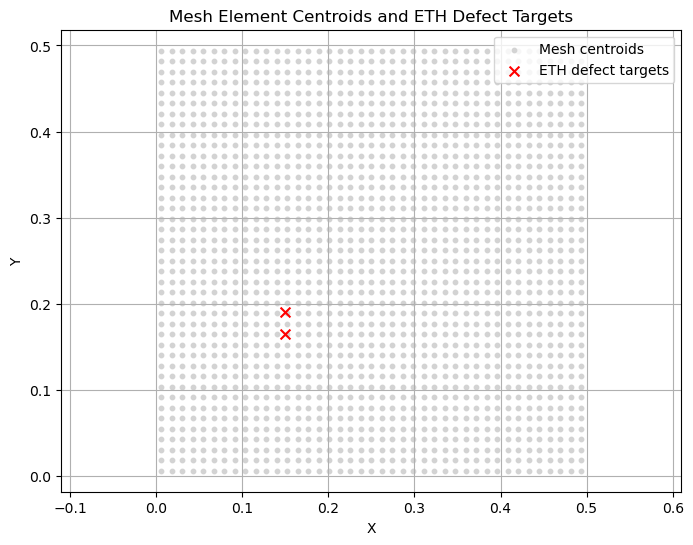

In [11]:
import matplotlib.pyplot as plt

# Plot centroids of all elements
plt.figure(figsize=(8, 6))
plt.scatter(centroids_x, centroids_y, s=10, c='lightgray', label='Mesh centroids')

# Overlay the ETH defect target locations
eth_x, eth_y = zip(*eth_coords)  # Unpack into separate x and y lists
plt.scatter(eth_x, eth_y, s=50, c='red', marker='x', label='ETH defect targets')

# Formatting
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Mesh Element Centroids and ETH Defect Targets")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()

In [20]:
# DEFECT A + B SIM
SIM_NAME_DEFECT_AC_SQUARE = "fz_defect_AC_square"

p.add_to_project(
    sn.UnstructuredMeshSimulationConfiguration(
        name=SIM_NAME_DEFECT_AC_SQUARE,
        unstructured_mesh=mesh_discrete_N_elements,
        event_configuration=ec,
    )
)

In [21]:

p.simulations.launch(
    simulation_configuration=SIM_NAME_DEFECT_AC_SQUARE,
    events=p.events.list(),
    site_name=SALVUS_FLOW_SITE_NAME,
    ranks_per_job=4,
    # extra_output_configuration={
    #     "surface_data": {
    #         "sampling_interval_in_time_steps": sb,
    #         "fields": ["velocity"],
    #         "side_sets": ["z1"],
    #     },
    # },
)

[2025-06-19 11:34:00,404] INFO: Submitting job array with 5 jobs ...


Initializing Jobs and Uploading Files for Individual Jobs:   0%|          | 0/5 [00:00<?, ?job/s]

5

In [22]:
p.simulations.query(block=True, ping_interval_in_seconds=5)

VBox()

True

In [23]:
# Create output folder
folder_name = os.path.join(PROJECT_DIR, SIM_NAME_DEFECT_AC_SQUARE, "ReceiverData")
os.makedirs(folder_name, exist_ok=True)
print(f"Folder '{folder_name}' created successfully!")

# Get all relevant waveform entries
ed = p.waveforms.get("fz_defect_AC_square", p.events.list())

# Loop over each source event (SRC 01 to SRC 05)
for i, SrcEvent in enumerate(ed):
    try:
        times, values = SrcEvent.get_data_cube(receiver_field="velocity", component="Z")
        
        # Construct the filename for each source
        savename = f"{SIM_NAME_DEFECT_AC_SQUARE}_SrcEvent{i+1:02d}.h5"
        savepath = os.path.join(folder_name, savename)
        
        # Save in MATLAB v7.3-compatible HDF5 format
        with h5py.File(savepath, 'w') as f:
            f.create_dataset('data', data=values)                # NxT array
            f.create_dataset('x', data=src_all[:, 0])            # Receiver X-coordinates
            f.create_dataset('y', data=src_all[:, 1])            # Receiver Y-coordinates
            f.create_dataset('z', data=src_all[:, 2])            # Receiver Y-coordinates
            f.create_dataset('time', data=times)          # Scalar as array
            f.create_dataset('label', data=np.string_('rec_data'))  # String

        print(f"Written: {savename}")
    
    except Exception as e:
        print(f"Skipping SrcEvent{i+1:02d} due to error: {e}")

Folder 'alu_plate_9mm_50x50cm_T10ms_Ricker_fc50kHz_Q_250/fz_defect_AC_square/ReceiverData' created successfully!
Written: fz_defect_AC_square_SrcEvent01.h5
Written: fz_defect_AC_square_SrcEvent02.h5
Written: fz_defect_AC_square_SrcEvent03.h5
Written: fz_defect_AC_square_SrcEvent04.h5
Written: fz_defect_AC_square_SrcEvent05.h5


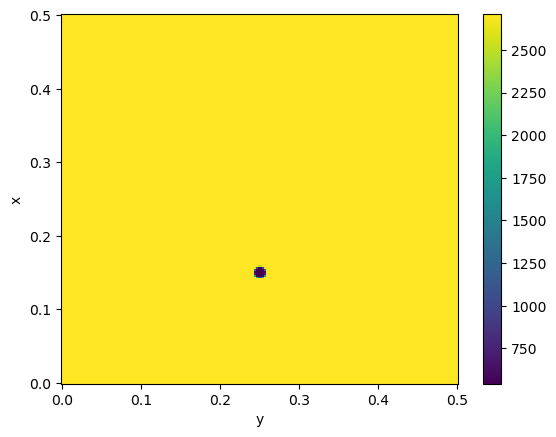

In [14]:

# Density Defect 
rho_defect = 0.2 * rho0

# DEFECT A
defect_x = 0.3 * x_max
defect_y = 0.5 * y_max

rho = xr.DataArray(
    data=smooth_defect_property(
        X,
        Y,
        center_x=defect_x,
        center_y=defect_y,
        size=0.015,
        taper_fraction=0.2,
        prop0=rho0,
        prop_defect=rho_defect,
    ),
    dims=["x", "y"],
    coords={"x": x, "y": y},
)

rho.plot()

material_varying = sn.material.from_params(
    vp=vp0,
    vs=vs0,
    rho=rho,
    qmu=Q,
    qkappa=Q,
)

# Because we can't attach linear solids to a material, we need to create a
# layered model with a single layer and no interfaces.
model = sn.layered_meshing.LayeredModel(
    strata=[material_varying],
    linear_solids=sn.LinearSolids(reference_frequency=fc),
)

mesh_defect_A = sn.layered_meshing.mesh_from_domain(
    domain=d,
    model=model,
    mesh_resolution=sn.MeshResolution(
        reference_frequency=2.5 * fc,
        elements_per_wavelength=2.0,
        model_order=4,
    ),
)

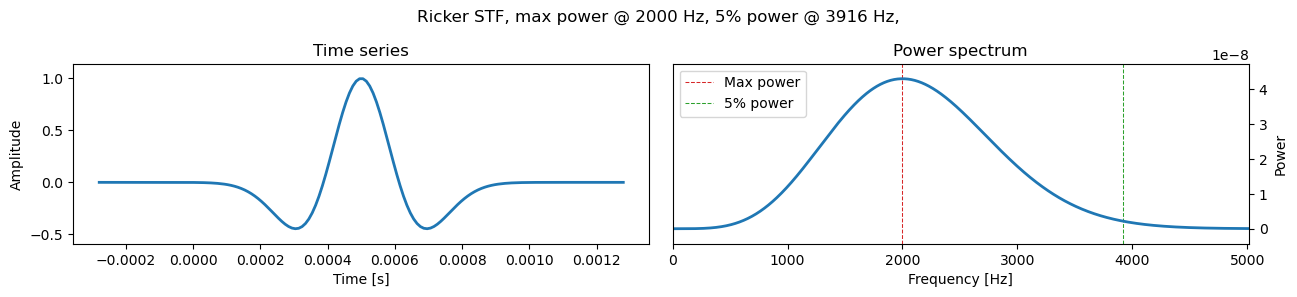

In [25]:
ec1 = sn.EventConfiguration(
    wavelet=sn.simple_config.stf.Ricker(
        center_frequency=2e3, time_shift_in_seconds=0.5e-3
    ),
    waveform_simulation_configuration=wsc,
)
ec1.wavelet.plot()

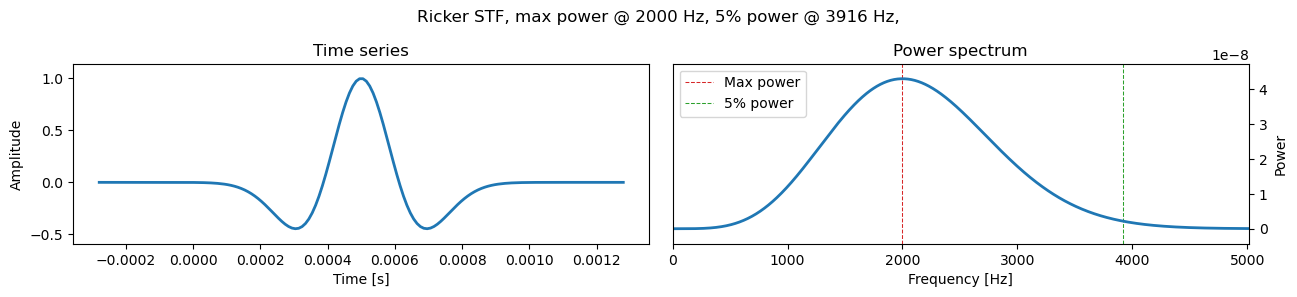

In [27]:
ec2 = sn.EventConfiguration(
    wavelet=sn.simple_config.stf.Ricker(
        center_frequency=10e3, time_shift_in_seconds=1.5e-3
    ),
    waveform_simulation_configuration=wsc,
)
ec1.wavelet.plot()

In [28]:
ec = ec1 + ec2
ec.wavelet.plot()

TypeError: unsupported operand type(s) for +: 'EventConfiguration' and 'EventConfiguration'